# Loading Data

In [46]:
import numpy as np

def get_data():
    data = np.genfromtxt('data.csv', delimiter=',')
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [ ]:
import json

def load(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs, targets

def get_data():
    return load("data.json")

# Neural Network

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [51]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.1968, Accuracy: 0.2581, Val Loss: 2.2055, Val Accuracy: 0.2510
Epoch 2/50, Loss: 2.1485, Accuracy: 0.3090, Val Loss: 2.1151, Val Accuracy: 0.3431
Epoch 3/50, Loss: 2.1040, Accuracy: 0.3541, Val Loss: 2.1072, Val Accuracy: 0.3518
Epoch 4/50, Loss: 2.0841, Accuracy: 0.3747, Val Loss: 2.0984, Val Accuracy: 0.3615
Epoch 5/50, Loss: 2.0684, Accuracy: 0.3880, Val Loss: 2.1063, Val Accuracy: 0.3521
Epoch 6/50, Loss: 2.0492, Accuracy: 0.4072, Val Loss: 2.0872, Val Accuracy: 0.3665
Epoch 7/50, Loss: 2.0291, Accuracy: 0.4288, Val Loss: 2.0719, Val Accuracy: 0.3855
Epoch 8/50, Loss: 2.0089, Accuracy: 0.4516, Val Loss: 2.0563, Val Accuracy: 0.4062
Epoch 9/50, Loss: 1.9918, Accuracy: 0.4671, Val Loss: 2.0703, Val Accuracy: 0.3842
Epoch 10/50, Loss: 1.9718, Accuracy: 0.4891, Val Loss: 2.0385, Val Accuracy: 0.4246
Epoch 11/50, Loss: 1.9553, Accuracy: 0.5074, Val Loss: 2.0278, Val Accuracy: 0.4329
Epoch 12/50, Loss: 1.9364, Accuracy: 0.5260, Val Loss: 2.0085, Val Accuracy: 0.4519
E

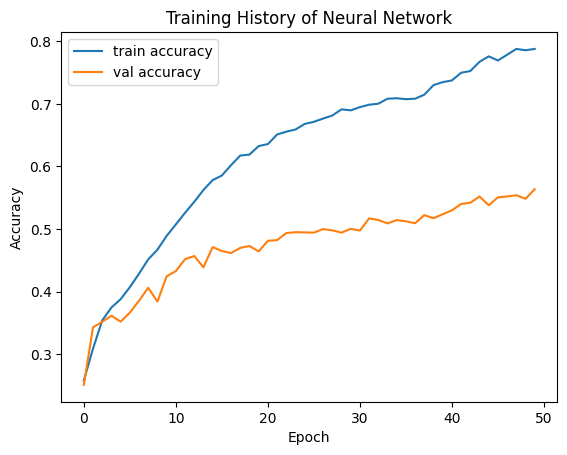

In [52]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

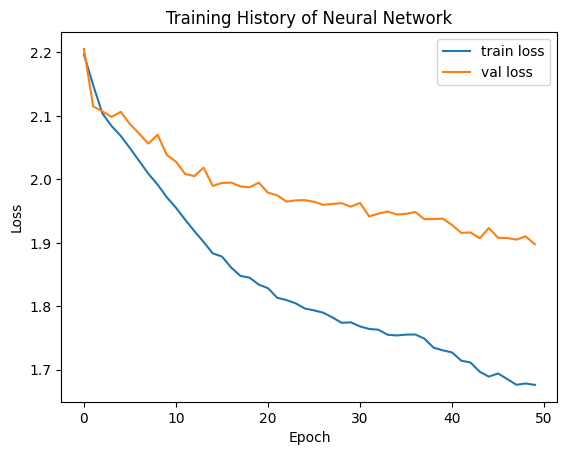

In [53]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [54]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.5637516688918558


# Convolutional Neural Network

# Recurrent Neural Network